In [1]:
from parcels import (
    FieldSet,
    JITParticle,
    ScipyParticle,
    ParticleSet,
    AdvectionRK4,
    AdvectionRK4_3D,
    StatusCode,
)
import parcels

import datetime as dt
from datetime import datetime, timedelta

import dask
from dask.distributed import Client

import numpy as np

from pathlib import Path
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cmocean

import xarray as xr
from glob import glob
import cartopy
import cartopy.crs as ccrs
import xoak
from time import time
import warnings

warnings.simplefilter("ignore")

In [2]:
# Parameters
RNG_seed = 123


# Time
year = 2016
start_month = 1
start_day = 1
end_month = 12
end_day = 31
max_age_d = 220
# timedirection
timearrow = 1
# Timestep in minutes
dt_in_minutes = 15
output_dt_in_minutes = 15


# Box traits
depth_m = 0

n_particles_per_cell = 10

repeated_release = True
repeatdt_d = 7

isPapermill = False


In [123]:
if not isPapermill:
    year = 2016
    start_month = 1
    start_day = 1
    end_month = 1
    end_day = 31
    max_age_d = 20
    # timedirection
    timearrow = 1
    # Timestep in minutes
    dt_in_minutes = 3*60
    output_dt_in_minutes = 12*60

    # Box traits
    depth_m = 0

    n_particles_per_cell = 10

    repeated_release = True
    repeatdt_d = 7

# Read Files

In [124]:
# Get Variables from Parameters
start_date = np.datetime64(f"{year}-{start_month:02d}-{start_day:02d}", "D")
end_date = np.datetime64(f"{year}-{end_month:02d}-{end_day:02d}", "D")
first_day_in_year = np.datetime64(f"{year}-01-01", "D")

start_date_str = start_date.astype(str).replace("-","")
end_date_str = end_date.astype(str).replace("-","")

start_file = (start_date - first_day_in_year).astype(int) * 4
if start_file > 0:
    start_file = start_file-1
end_file = (end_date - first_day_in_year + 1).astype(int) * 4+1

runtime_in_days = (end_date - start_date).tolist()
dt_min = np.timedelta64(dt_in_minutes, "m").tolist()
dt_out_min = np.timedelta64(output_dt_in_minutes, "m").tolist()

np.random.seed(RNG_seed)
save_path = f"/gxfs_work/geomar/smomw597/2025_Fucus/output/Trajectories/{year}/"

print(start_file,end_file)

0 125


In [125]:
# Read Files
data_path_orig_files = Path("/gxfs_work/geomar/smomw400/bsh_operationalmodel_data/")
data_path_divz_files = Path("/gxfs_work/geomar/smomw122/bsh_operationalmodel_data/")
data_path_static_files = Path("/gxfs_work/geomar/smomw122/bsh_operationalmodel_data")
data_path_static_fine = data_path_static_files / "static_file_fine"
data_path_static_coarse = data_path_static_files / "static_file_coarse"

sigma_file_fine = data_path_static_fine / "sigma_file_fine.nc"
H0_file_fine = data_path_static_fine / "H0_file_fine.nc"
divH0_file_fine = data_path_static_fine / "divH0_file_fine.nc"
lonlat_file_fine = data_path_static_fine / "lonlat_file_fine.nc"

c_files_fine = sorted(data_path_orig_files.glob(f"c_file_fine_{year}/*"))[start_file:end_file]
z_files_fine = sorted(data_path_orig_files.glob(f"z_file_fine_{year}/*"))[start_file:end_file]
t_files_fine = sorted(data_path_orig_files.glob(f"t_file_fine_{year}/*"))[start_file:end_file]
divz_files_fine = sorted(data_path_divz_files.glob(f"divz_file_fine_{year}/*"))[start_file:end_file]

sigma_file_coarse = data_path_static_coarse / "sigma_file_coarse.nc"
H0_file_coarse = data_path_static_coarse / "H0_file_coarse.nc"
divH0_file_coarse = data_path_static_coarse / "divH0_file_coarse.nc"
lonlat_file_coarse = data_path_static_coarse / "lonlat_file_coarse.nc"

c_files_coarse = sorted(data_path_orig_files.glob(f"c_file_coarse_{year}/*"))[start_file:end_file]
z_files_coarse = sorted(data_path_orig_files.glob(f"z_file_coarse_{year}/*"))[start_file:end_file]
t_files_coarse = sorted(data_path_orig_files.glob(f"t_file_coarse_{year}/*"))[start_file:end_file]
divz_files_coarse = sorted(data_path_divz_files.glob(f"divz_file_coarse_{year}/*"))[start_file:end_file]

In [126]:
# open eta and H0 files
ds_eta_fine = xr.open_dataset(z_files_fine[0])
ds_H0_fine = xr.open_dataset(H0_file_fine)

ds_eta_coarse = xr.open_dataset(z_files_coarse[0])
ds_H0_coarse = xr.open_dataset(H0_file_coarse)

# Functions

In [127]:
# https://github.com/Yichabod/natural_disaster_pred/blob/master/cropping_coordinates.py

earth_radius = 6271.0
degrees_to_radians = np.pi / 180.0
radians_to_degrees = 180.0 / np.pi


def change_in_latitude(kms):
    "Given a distance north, return the change in latitude."
    return (kms / earth_radius) * radians_to_degrees


def change_in_longitude(latitude, kms):
    "Given a latitude and a distance west, return the change in longitude."
    # Find the radius of a circle around the earth at given latitude.
    r = earth_radius * np.cos(np.multiply(latitude, degrees_to_radians))
    return (kms / r) * radians_to_degrees

In [128]:
# Draw uniformly distributed random positions on the globe
def get_uniform_random_latlon_in(
    lat_min, lat_max,
    lon_min, lon_max,
    n_particles_per_cell,
):
    lat = np.random.uniform(
        lat_min, lat_max,
        size=n_particles_per_cell,
    )
    lon = np.random.uniform(
        lon_min, lon_max,
        size=n_particles_per_cell,
    )
    return lat, lon

# Samples

In [129]:
suptitle_size = 20
title_size = 16
mapsize = (16, 8)
extent = (2.5, 27.5, 52, 62)
lonmid = np.mean(extent[:2])
latmid = np.mean(extent[:2])
map_projection = ccrs.Stereographic(
    central_longitude=lonmid, central_latitude=latmid,
    )
def basemap(ax):
    ax.set_extent(extent, ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND)
    ax.add_feature(cartopy.feature.COASTLINE)
    ax.gridlines(draw_labels=["left", "bottom"], y_inline=False,)
    return ax

In [130]:
working_directory = Path("/gxfs_work/geomar/smomw597/2025_Fucus/2025_fucus-dispersal/Fucus_location_shp")
location_file = Path(working_directory, "REDLIST_SIS_Macrophytes.shp")
gdf_release_area = gpd.read_file(location_file)

In [131]:
gdf_release_area = gdf_release_area.drop(gdf_release_area[gdf_release_area.F_vesiculo ==0].index).to_crs(crs=ccrs.Geodetic()).assign(area_m2 = gdf_release_area.to_crs(crs=ccrs.AlbersEqualArea()).area)
gdf_release_area = gdf_release_area[["CELLCODE", "F_vesiculo", "geometry"]]
gdf_release_area

,CELLCODE,F_vesiculo,geometry
49699,10kmE488N418,2,"POLYGON ((20.14019 60.35963, 20.16755 60.44855..."
49700,10kmE489N414,2,"POLYGON ((20.20947 59.99111, 20.23662 60.08001..."
49701,10kmE489N418,2,"POLYGON ((20.31906 60.34667, 20.34688 60.43555..."
49702,10kmE492N414,2,"POLYGON ((20.7398 59.95138, 20.7683 60.04015, ..."
49703,10kmE492N418,2,"POLYGON ((20.85486 60.30645, 20.88407 60.39521..."
...,...,...,...
51213,10kmE513N397,3,"POLYGON ((23.80809 58.12399, 23.8422 58.21194,..."
51214,10kmE515N399,3,"POLYGON ((24.21081 58.26466, 24.24609 58.35249..."
51215,10kmE515N420,2,"POLYGON ((24.99658 60.10714, 25.0365 60.19477,..."
51216,10kmE516N397,3,"POLYGON ((24.30702 58.07114, 24.34228 58.15895..."


In [132]:
n_release_cells = gdf_release_area.shape[0]
n_particles = n_release_cells*n_particles_per_cell

In [133]:
import shapely
def relative_position_in_cell(x_rel: float, y_rel: float, cell: shapely.Polygon):
    (x0, y0), (x1,y1), (x2,y2), (x3,y3), (x4,y4) = cell.exterior.coords
    ex = (x3-x0, y3-y0)
    ey = (x1-x0, y1-y0)
    return x0 + x_rel * ex[0] + y_rel * ey[0], y0 + x_rel * ex[1] + y_rel * ey[1]

In [134]:
lon, lat, cellcode, observation_period = list(
    zip(
        *[
            relative_position_in_cell(rand_x, rand_y, gdf_release_area.iloc[rand_cell].geometry) 
            + (gdf_release_area.CELLCODE.iloc[rand_cell],)
            + (gdf_release_area.F_vesiculo.iloc[rand_cell],)
            for rand_x, rand_y, rand_cell in zip(
                np.random.uniform(0, 1, size=n_particles),
                np.random.uniform(0, 1, size=n_particles),
                np.random.randint(0, len(gdf_release_area), size=n_particles),
            )
        ]
    )
)

In [135]:
lons = np.array(lon)
lats = np.array(lat)
release_depth = np.zeros_like(lons)

In [ ]:
# # # Make release box
# # lat_release_min = lat_site - change_in_latitude(box_side_length_km / 2)
# # lat_release_max = lat_site + change_in_latitude(box_side_length_km / 2)
# # lon_release_min = lon_site - change_in_longitude(lat_site, box_side_length_km / 2)
# # lon_release_max = lon_site + change_in_longitude(lat_site, box_side_length_km / 2)

# # Make Box around release box, to ensure that depth values are existent while establishing particles
# lat_box_min = lat_site - change_in_latitude(box_side_length_km * 2)
# lat_box_max = lat_site + change_in_latitude(box_side_length_km * 2)
# lon_box_min = lon_site - change_in_longitude(lat_site, box_side_length_km * 2)
# lon_box_max = lon_site + change_in_longitude(lat_site, box_side_length_km * 2)

NameError: name 'lat_site' is not defined

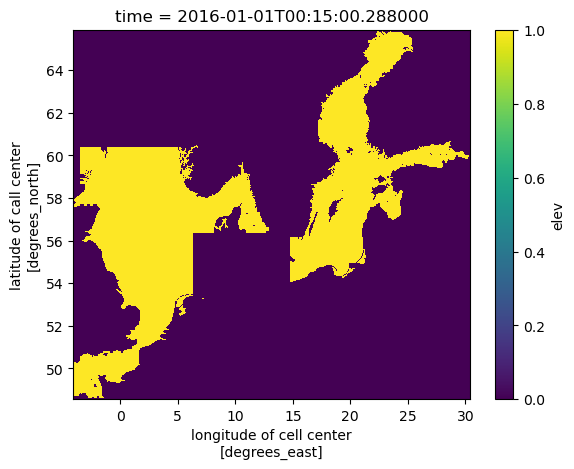

In [ ]:
# fig, ax = plt.subplots()
# ds_eta_coarse.elev.isel(time=0).notnull().plot(ax=ax)
# # ds_eta_fine.elev.isel(time=0).notnull().plot(ax=ax)
# plt.show()

In [ ]:
# # Build masks
# fine_mask = (
#     (ds_eta_fine.lat >= lat_site)
#     & (ds_eta_fine.lat <= lat_site)
#     & (ds_eta_fine.lon >= lon_site)
#     & (ds_eta_fine.lon <= lon_site)
# )
# coarse_mask = (
#     (ds_eta_coarse.lat >= lat_site)
#     & (ds_eta_coarse.lat <= lat_site)
#     & (ds_eta_coarse.lon >= lon_site)
#     & (ds_eta_coarse.lon <= lon_site)
# )

ValueError: ('Lengths must match to compare', (51300,), (387,))

In [ ]:
# # Check if area is in fine grid or not
# if fine_mask.sum() == 0:
#     region_mask = coarse_mask
#     elev = ds_eta_coarse.elev.isel(time=0, drop=True)
#     h0 = ds_H0_coarse.H0
# else:
#     region_mask = fine_mask
#     elev = ds_eta_fine.elev.isel(time=0, drop=True)
#     h0 = ds_H0_fine.H0

# # only seed in water
# elev_mask = ~ elev.isnull()

# # avoid weird H0 < 0 locations
# h0_mask = h0 > 0

In [ ]:
# # Check where to place the particles horizontaly and the fraction of valid cells
# seed_here = (
#     (elev_mask & h0_mask)
#     .where(region_mask, drop=True)
#     .astype(bool)
# )
# fraction_valid_horizontal = seed_here.mean().data
# if fraction_valid_horizontal > 0:
#     number_horizontal = int(n_particles_per_cell / fraction_valid_horizontal * 1.25)
#     seasurface_height = (
#         (elev + h0)
#         .where((region_mask & h0_mask), drop=True)
#     )
# else:
#     print("Es ist ein Fehler aufgetreten")

In [ ]:
# # Generate lats and lons
# # uniformly distributed everywhere
# # uniform in lat / lon =/= uniform in m2
# release_lats = np.random.uniform(lat_release_min, lat_release_max, size=number_horizontal)
# release_lons = np.random.uniform(lon_release_min, lon_release_max, size=number_horizontal)

# # check validity of positions
# # note that this is _not_ per water volume but per sigma!
# seedable = seed_here.sel(
#     lon=xr.DataArray(release_lons, dims="particle"),
#     lat=xr.DataArray(release_lats, dims="particle"),
#     method="nearest",
# ).data

# # remove invalide positions and cut to legth afterwards
# release_lons = release_lons[seedable][:n_particles_per_cell]
# release_lats = release_lats[seedable][:n_particles_per_cell]
# release_depth = np.zeros_like(release_lons)

# Parcels

## Custom Kernel

In [138]:
# def DeleteErrorParticle(particle, fieldset, time):
#     if particle.state >= 50:  # This captures all Errors
#         particle.delete()

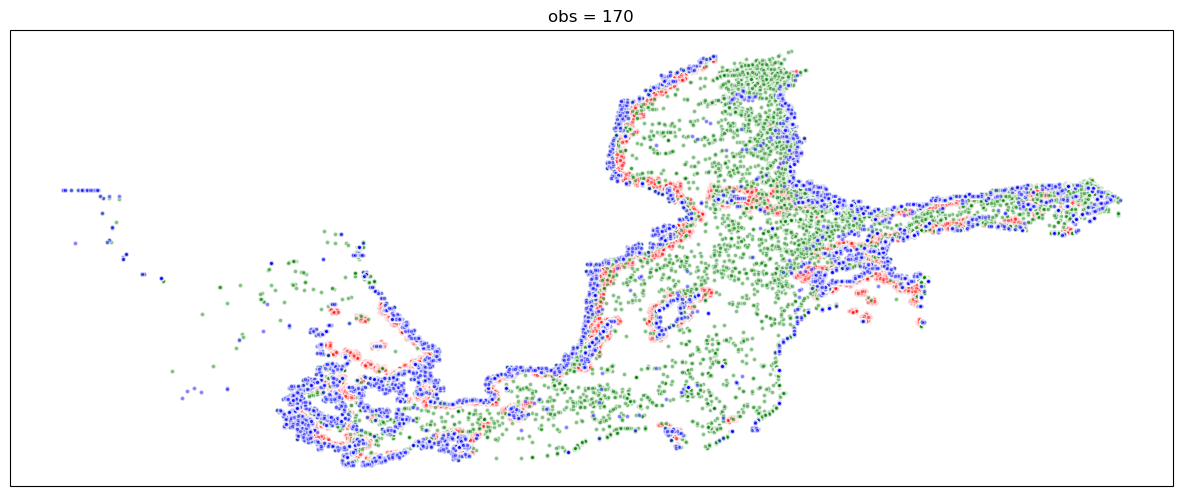

In [139]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(
    1,1,1,
    projection= ccrs.PlateCarree(),
)
ds_trajectories.isel(obs=0).plot.scatter(x="lon", y="lat", s=10, c="r", ax=ax, alpha=.5)
ds_trajectories.isel(obs=90).plot.scatter(x="lon", y="lat", s=10, c="g", ax=ax, alpha=.5)
ds_trajectories.isel(obs=170).plot.scatter(x="lon", y="lat", s=10, c="b", ax=ax, alpha=.5)
plt.show()

In [140]:
def AdvectionRK4_3D_SIGMABSH(particle, fieldset, time):
    # max_depth_m = 25
    max_depth_m = fieldset.max_depth
    time0 = time
    sig0 = particle.depth
    lat0 = particle.lat
    lon0 = particle.lon

    (u1, v1) = fieldset.UV[time0, sig0, lat0, lon0]  # horizontal velocities in deg/s

    w1 = fieldset.Wz[time0, sig0, lat0, lon0]  # this is upward in m/s rel to sig0 level

    s1 = fieldset.S[time0, sig0, lat0, lon0]
    t1 = fieldset.T[time0, sig0, lat0, lon0]

    eta1 = fieldset.eta[time0, 0, lat0, lon0]  # sea level elevation
    detadlon1 = fieldset.detadlon[time0, 0, lat0, lon0]
    detadlat1 = fieldset.detadlat[time0, 0, lat0, lon0]
    h01 = fieldset.H0[0, 0, lat0, lon0]  # reference bottom depth (for eta=0)
    dh0dlon1 = fieldset.dH0dlon[0, 0, lat0, lon0]
    dh0dlat1 = fieldset.dH0dlat[0, 0, lat0, lon0]
    h1 = h01 + eta1  # total height of water column

    wsigma1 = -w1 / h1 - sig0 / h1 * (
        u1 * (detadlon1 + dh0dlon1) + v1 * (detadlat1 + dh0dlat1)
    )*1e-6

    time1 = time0 + 0.5 * particle.dt
    sig1 = max(
        0.0,
        min(min(1.0, max_depth_m / (eta1 + h01)), sig0 + wsigma1 * 0.5 * particle.dt),
    )*1e-6

    lat1 = lat0 + v1 * 0.5 * particle.dt
    lon1 = lon0 + u1 * 0.5 * particle.dt

    (u2, v2) = fieldset.UV[time1, sig1, lat1, lon1]

    w2 = fieldset.Wz[time1, sig1, lat1, lon1]*1e-6

    eta2 = fieldset.eta[time1, 0, lat1, lon1]
    detadlon2 = fieldset.detadlon[time1, 0, lat1, lon1]
    detadlat2 = fieldset.detadlat[time1, 0, lat1, lon1]
    h02 = fieldset.H0[0, 0, lat1, lon1]
    dh0dlon2 = fieldset.dH0dlon[0, 0, lat1, lon1]
    dh0dlat2 = fieldset.dH0dlat[0, 0, lat1, lon1]
    h2 = h02 + eta2

    wsigma2 = -w2 / h2 - sig1 / h2 * (
        u2 * (detadlon2 + dh0dlon2) + v2 * (detadlat2 + dh0dlat2)
    )*1e-6

    time2 = time0 + 0.5 * particle.dt
    sig2 = max(
        0.0,
        min(min(1.0, max_depth_m / (eta2 + h02)), sig0 + wsigma2 * 0.5 * particle.dt),
    )*1e-6
    lat2 = lat0 + v2 * 0.5 * particle.dt
    lon2 = lon0 + u2 * 0.5 * particle.dt

    (u3, v3) = fieldset.UV[time2, sig2, lat2, lon2]

    w3 = fieldset.Wz[time2, sig2, lat2, lon2]

    eta3 = fieldset.eta[time2, 0, lat2, lon2]
    detadlon3 = fieldset.detadlon[time2, 0, lat2, lon2]
    detadlat3 = fieldset.detadlat[time2, 0, lat2, lon2]
    h03 = fieldset.H0[0, 0, lat2, lon2]
    dh0dlon3 = fieldset.dH0dlon[0, 0, lat2, lon2]
    dh0dlat3 = fieldset.dH0dlat[0, 0, lat2, lon2]
    h3 = h03 + eta3

    wsigma3 = -w3 / h3 - sig2 / h3 * (
        u3 * (detadlon3 + dh0dlon3) + v3 * (detadlat3 + dh0dlat3)
    )*1e-6

    time3 = time0 + particle.dt
    sig3 = max(
        0.0, min(min(1.0, max_depth_m / (eta3 + h03)), sig0 + wsigma3 * particle.dt)
    )*1e-6
    lat3 = lat0 + v3 * particle.dt
    lon3 = lon0 + u3 * particle.dt

    (u4, v4) = fieldset.UV[time3, sig3, lat3, lon3]

    w4 = fieldset.Wz[time3, sig3, lat3, lon3]

    eta4 = fieldset.eta[time3, 0, lat3, lon3]
    detadlon4 = fieldset.detadlon[time3, 0, lat3, lon3]
    detadlat4 = fieldset.detadlat[time3, 0, lat3, lon3]
    h04 = fieldset.H0[0, 0, lat3, lon3]
    dh0dlon4 = fieldset.dH0dlon[0, 0, lat3, lon3]
    dh0dlat4 = fieldset.dH0dlat[0, 0, lat3, lon3]
    h4 = h04 + eta4

    wsigma4 = -w4 / h4 - sig3 / h4 * (
        u4 * (detadlon4 + dh0dlon4) + v4 * (detadlat4 + dh0dlat4)
    )*1e-6

    lon4 = lon0 + (u1 + 2 * u2 + 2 * u3 + u4) / 6 * particle.dt
    lat4 = lat0 + (v1 + 2 * v2 + 2 * v3 + v4) / 6 * particle.dt
    sig4 = max(
        0.0,
        min(
            min(1.0, max_depth_m / (eta4 + h04)),
            sig0 + (wsigma1 + 2 * wsigma2 + 2 * wsigma3 + wsigma4) / 6 * particle.dt,
        ),
    )*1e-6

    particle_dlon += lon4 - lon0
    particle_dlat += lat4 - lat0
    particle_ddepth += sig4 - sig0

    particle.eta = eta1
    particle.h0 = h01
    particle.wz = w1
    particle.u = u1
    particle.v = v1
    particle.wsigma = wsigma1
    particle.S = s1
    particle.T = t1
    particle.d = particle.depth


In [141]:
CustomKernel = AdvectionRK4_3D_SIGMABSH

## Particles

In [ ]:
# dim_dict_lonlat = dict(lon="lon", lat="lat")
# dim_dict_lonlat_time = dict(dim_dict_lonlat, time="time")
# dim_dict_lonlat_time_depth = dict(dim_dict_lonlat_time, depth = "sigma")

In [ ]:
# # Prepare reading of variables
# fieldset_variables = ["U", "V",]
# variable_names = ["uvel", "vvel",]
# dim_dicts = [dim_dict_lonlat_time, dim_dict_lonlat_time, ]
# interp_methods = ["cgrid_velocity", "cgrid_velocity",]

# variables = dict(zip(fieldset_variables, variable_names))
# dimensions = dict(zip(fieldset_variables, dim_dicts))
# interp_method = dict(zip(fieldset_variables, interp_methods))

In [150]:
# Establish particle variables
particle_variables = (
    "eta", "h0", "wz", 
    "u", "v", "wsigma", 
    "S", "T", "d",
)
SampleParticle = parcels.JITParticle.add_variables(particle_variables)

In [151]:
# Prepare reading of variables
fieldset_variables = [
    "U", "V", "Wz", 
    "H0", "dH0dlon", "dH0dlat",
    "eta", "detadlon", "detadlat",
]
variable_names = ["uvel", "vvel", "wvel", 
    "H0", "dH0dlon", "dH0dlat",
    "eta", "detadlon", "detadlat"
]
dim_dicts = [
    dim_dict_lonlat_time_depth, dim_dict_lonlat_time_depth, dim_dict_lonlat_time_depth,
    dim_dict_lonlat, dim_dict_lonlat, dim_dict_lonlat, 
    dim_dict_lonlat_time, dim_dict_lonlat_time, dim_dict_lonlat_time,
]
interp_methods = [
    "cgrid_velocity", "cgrid_velocity", "cgrid_velocity",
    "cgrid_tracer", "cgrid_tracer", "cgrid_tracer",
    "cgrid_velocity", "cgrid_velocity", "cgrid_velocity",
]

variables = dict(zip(fieldset_variables, variable_names))
dimensions = dict(zip(fieldset_variables, dim_dicts))
interp_method = dict(zip(fieldset_variables, interp_methods))

In [152]:
# Prepare reading of variables
variables = {
    "U": "uvel", "V": "vvel", "Wz": "wvel", 
    "H0": "H0", "dH0dlon": "dH0dlon", "dH0dlat": "dH0dlat",
    "eta": "elev", "detadlon": "detadlon", "detadlat": "detadlat",
}

dimensions = {
    "U": dim_dict_lonlat_time_depth,
    "V": dim_dict_lonlat_time_depth,
    "Wz": dim_dict_lonlat_time_depth,
    "H0": dim_dict_lonlat,
    "dH0dlon": dim_dict_lonlat,
    "dH0dlat": dim_dict_lonlat,
    "eta": dim_dict_lonlat_time,
    "detadlon": dim_dict_lonlat_time,
    "detadlat": dim_dict_lonlat_time,
}

interp_method = {
    "U": "cgrid_velocity", "V": "cgrid_velocity", "Wz": "cgrid_velocity",
    "H0": "cgrid_tracer", "dH0dlon": "cgrid_tracer", "dH0dlat": "cgrid_tracer",
    "eta": "cgrid_velocity", "detadlon": "cgrid_velocity", "detadlat": "cgrid_velocity",
}

In [153]:
# # Prepare reading of variables
# variables = dict(U="uvel", V="vvel")

# dimensions = dict(U=dim_dict_lonlat_time, V=dim_dict_lonlat_time,)

# interp_method = dict(
#     U="cgrid_velocity", V="cgrid_velocity",
# )

## Fieldset

### fine fieldset

In [154]:
lonlat_dict_fine = {
    "lon": lonlat_file_fine,
    "lat": lonlat_file_fine,
}
current_dict_fine = dict(
    lonlat_dict_fine, 
    depth=sigma_file_fine,
    data=c_files_fine,
)
H0_dict_fine = dict(lonlat_dict_fine, data=H0_file_fine)
divH0_dict_fine = dict(lonlat_dict_fine, data=divH0_file_fine)
divz_dict_fine = dict(lonlat_dict_fine, data=divz_files_fine)
eta_dict_fine = dict(lonlat_dict_fine, data=z_files_fine)

In [164]:

st_dict_fine = dict(
    lonlat_dict_fine,
    depth=sigma_file_fine,
    data=t_files_fine,
)


# Build fine fieldset for Temp and salinity
st_names_fine = {
    "S": st_dict_fine,
    "T": st_dict_fine,
}
st_fieldset_fine = FieldSet.from_netcdf(
    filenames=st_names_fine,
    variables={
        "S": "salt",
        "T": "temp",
    },
    dimensions={
        "S": dim_dict_lonlat_time_depth,
        "T": dim_dict_lonlat_time_depth,
    },
    interp_method={
        "S": "cgrid_tracer",
        "T": "cgrid_tracer",
    },
    allow_time_extrapolation=False,
    gridindexingtype="nemo",
)



In [155]:
# Build fine fieldset for all the other Values
# filenames_fine = dict(V=current_dict_fine, U=current_dict_fine,)


# Build fine fieldset for all the other Values
filenames_fine = {
    "V": current_dict_fine,
    "U": current_dict_fine,
    "Wz": current_dict_fine,
    "H0": H0_dict_fine,
    "dH0dlon": divH0_dict_fine,
    "dH0dlat": divH0_dict_fine,
    "eta": eta_dict_fine,
    "detadlon": divz_dict_fine,
    "detadlat": divz_dict_fine,
}

fieldset_fine = FieldSet.from_netcdf(
    filenames=filenames_fine,
    variables=variables,
    dimensions=dimensions,
    interp_method=interp_method,
    allow_time_extrapolation=True,
    gridindexingtype="nemo",
)

### coarse fieldsets

In [156]:
lonlat_dict_coarse = dict(lon=lonlat_file_coarse, lat=lonlat_file_coarse,)

current_dict_coarse = dict(
    lonlat_dict_coarse, 
    depth=sigma_file_coarse,
    data=c_files_coarse,
)
H0_dict_coarse = dict(lonlat_dict_coarse, data=H0_file_coarse)
divH0_dict_coarse = dict(lonlat_dict_coarse, data=divH0_file_coarse)
eta_dict_coarse = dict(lonlat_dict_coarse, data=z_files_coarse)
divz_dict_coarse = dict(lonlat_dict_coarse, data=divz_files_coarse)

In [165]:

st_dict_coarse = dict(
    lonlat_dict_coarse,
    depth=sigma_file_coarse,
    data=t_files_coarse,
)
# Build coarse fieldset for Temp and salinity
st_names_coarse = {
    "S": st_dict_coarse,
    "T": st_dict_coarse,
}
st_fieldset_coarse = FieldSet.from_netcdf(
    filenames=st_names_coarse,
    variables={
        "S": "salt",
        "T": "temp",
    },
    dimensions={
        "S": dim_dict_lonlat_time_depth,
        "T": dim_dict_lonlat_time_depth,
    },
    interp_method={
        "S": "cgrid_tracer",
        "T": "cgrid_tracer",
    },
    allow_time_extrapolation=False,
    gridindexingtype="nemo",
)

In [157]:
# Build coarse fieldset for all the other Values
# filenames_coarse = {
#     "U": current_dict_coarse,
#     "V": current_dict_coarse,
# }



# Build coarse fieldset for all the other Values
filenames_coarse = {
    "U": current_dict_coarse,
    "V": current_dict_coarse,
    "Wz": current_dict_coarse,
    "H0": H0_dict_coarse,
    "dH0dlon": divH0_dict_coarse,
    "dH0dlat": divH0_dict_coarse,
    "eta": eta_dict_coarse,
    "detadlon": divz_dict_coarse,
    "detadlat": divz_dict_coarse,
}

fieldset_coarse = FieldSet.from_netcdf(
    filenames=filenames_coarse,
    variables=variables,
    dimensions=dimensions,
    interp_method=interp_method,
    allow_time_extrapolation=True,
    gridindexingtype="nemo",
)

### Nested fieldset

In [60]:
# Build Nested field from the fine and coarse fields
U = parcels.NestedField("U", [fieldset_fine.U, fieldset_coarse.U])
V = parcels.NestedField("V", [fieldset_fine.V, fieldset_coarse.V])

nested_fieldset = FieldSet(U, V)


In [176]:
# Build Nested field from the fine and coarse fields
U = parcels.NestedField("U", [fieldset_fine.U, fieldset_coarse.U])
V = parcels.NestedField("V", [fieldset_fine.V, fieldset_coarse.V])

nested_fieldset = FieldSet(U, V)

Wz_add = parcels.NestedField("Wz", [fieldset_fine.Wz, fieldset_coarse.Wz])
H0_add = parcels.NestedField("H0", [fieldset_fine.H0, fieldset_coarse.H0])
dH0dlon_add = parcels.NestedField("dH0dlon", [fieldset_fine.dH0dlon, fieldset_coarse.dH0dlon])
dH0dlat_add = parcels.NestedField("dH0dlat", [fieldset_fine.dH0dlat, fieldset_coarse.dH0dlat])
eta_add = parcels.NestedField("eta", [fieldset_fine.eta, fieldset_coarse.eta])
detadlon_add = parcels.NestedField("detadlon", [fieldset_fine.detadlon, fieldset_coarse.detadlon])
detadlat_add = parcels.NestedField("detadlat", [fieldset_fine.detadlat, fieldset_coarse.detadlat])
S_add = parcels.NestedField("S", [st_fieldset_fine.S, st_fieldset_coarse.S])
T_add = parcels.NestedField("T", [st_fieldset_fine.T, st_fieldset_coarse.T])

In [177]:
# Combine the Nested Fields to a single nested field
nested_fieldset.add_field(Wz_add)
nested_fieldset.add_field(H0_add)
nested_fieldset.add_field(dH0dlon_add)
nested_fieldset.add_field(dH0dlat_add)
nested_fieldset.add_field(eta_add)
nested_fieldset.add_field(detadlon_add)
nested_fieldset.add_field(detadlat_add)
nested_fieldset.add_field(S_add)
nested_fieldset.add_field(T_add)
# Establish max depth and max age as constant in Fieldset
nested_fieldset.add_constant("max_depth", 25)
# nested_fieldset.add_constant("max_age_d", max_age_d)



# Create Particles

In [178]:
# Build Particle Set
start_time = np.datetime64(f'{year}-{start_month:02d}-{start_day:02d}T00:00:00')

pset = ParticleSet(
    fieldset=nested_fieldset,
    pclass=parcels.JITParticle,
    lat=lats,
    lon=lons,
    depth=release_depth,
    time=[start_time for n in range(n_particles)],
    repeatdt=timedelta(days=repeatdt_d),
)
if not repeated_release:
    pset.repeatdt = None

In [179]:
filename_time = f"{start_date_str}-{end_date_str}_dt{output_dt_in_minutes}min"
filename = f"Nested_{filename_time}_N{n_particles_per_cell}_seed{RNG_seed}.zarr"
# define Output path and name
if isPapermill:
    output_filename = str("PPmill_" + filename)
else:
    output_filename = str("TEST_" + filename)

output_path = Path(save_path, output_filename)
print(f"{output_path}")

/gxfs_work/geomar/smomw597/2025_Fucus/output/Trajectories/2016/TEST_Nested_20160101-20160131_dt720min_N10_seed123.zarr


In [180]:
# Define Outputparameters
output_particle_file = pset.ParticleFile(
    name=output_path,
    outputdt=dt_out_min,
    chunks=(n_particles, int(24 * 60 / output_dt_in_minutes)),
)

# Execute

In [181]:
# Execute Simulation
pset.execute(
    CustomKernel,
    dt=dt_min,
    runtime=runtime_in_days,
    output_file=output_particle_file,
    verbose_progress=True,
)

AttributeError: Particle type JITParticle does not define attribute 'eta. Please add 'eta' as a Variable in JITParticle.

# Analysis

## Read files

In [ ]:
# output_path = Path(save_path)

In [70]:
ds_trajectories = xr.open_zarr(output_path).compute()
# ds_trajectories["age_day"] = (ds_trajectories.age_sec/(60*60*24)).compute()
# depth_m = ds_trajectories.eta - ds_trajectories.z * (
#     ds_trajectories.eta + ds_trajectories.h0
# )
# ds_trajectories = ds_trajectories.assign(depth=depth_m)
ds_trajectories

<xarray.Dataset> Size: 654MB
Dimensions:     (trajectory: 113360, obs: 180)
Coordinates:
  * obs         (obs) int32 720B 0 1 2 3 4 5 6 7 ... 173 174 175 176 177 178 179
  * trajectory  (trajectory) int64 907kB 8720 8721 8722 ... 122077 122078 122079
Data variables:
    lat         (trajectory, obs) float64 163MB 61.51 61.59 61.64 ... nan nan
    lon         (trajectory, obs) float64 163MB 17.25 17.33 17.36 ... nan nan
    time        (trajectory, obs) datetime64[ns] 163MB 2016-01-01T02:44:59.71...
    z           (trajectory, obs) float64 163MB 0.0 0.0 0.0 0.0 ... nan nan nan
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        JITParticleAdvectionRK4DeleteErrorParticle
    parcels_mesh:           spherical
    parcels_version:        3.0.6

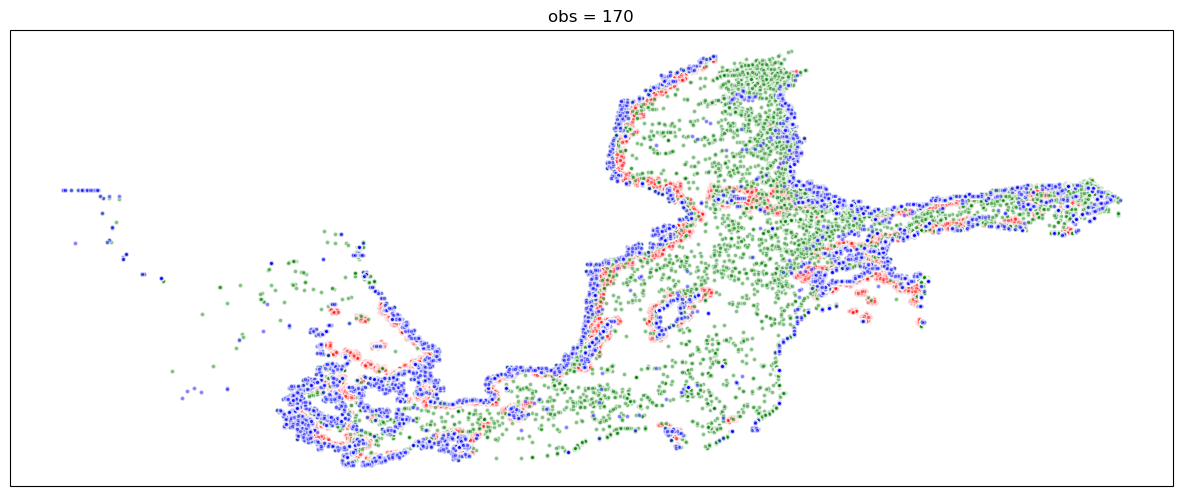

In [121]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(
    1,1,1,
    projection= ccrs.PlateCarree(),
)
ds_trajectories.isel(obs=0).plot.scatter(x="lon", y="lat", s=10, c="r", ax=ax, alpha=.5)
ds_trajectories.isel(obs=90).plot.scatter(x="lon", y="lat", s=10, c="g", ax=ax, alpha=.5)
ds_trajectories.isel(obs=170).plot.scatter(x="lon", y="lat", s=10, c="b", ax=ax, alpha=.5)
plt.show()

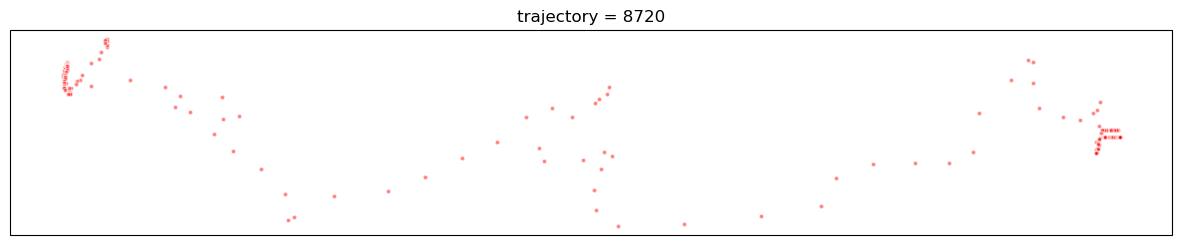

In [120]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(
    1,1,1,
    projection= ccrs.PlateCarree(),
)
ds_trajectories.isel(trajectory=0).plot.scatter(x="lon", y="lat", s=10, c="r", ax=ax, alpha=.5)
# ds_trajectories.isel(obs=90).plot.scatter(x="lon", y="lat", s=10, c="g", ax=ax, alpha=.5)
# ds_trajectories.isel(obs=179).plot.scatter(x="lon", y="lat", s=10, c="b", ax=ax, alpha=.5)
plt.show()

## Time plots

In [ ]:
# for i in np.arange(ds_trajectories.trajectory.shape[0] / number_particles):
#     traj_i = int(i*number_particles)
#     plt.plot(
#         ds_trajectories.time.isel(trajectory=traj_i),
#         ds_trajectories.age_sec.isel(trajectory=traj_i) / 3600,
#     )
# plt.show()

In [ ]:
# ds_trajectories.age_day.plot()

## Maps

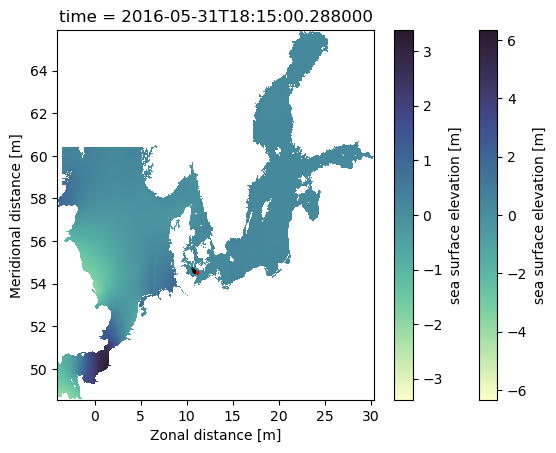

In [ ]:
# traj = ds_trajectories  # .isel(obs=671)#.isel(trajectory=6)
# # fieldset_NF
# # plt.pcolormesh(ds_eta_fine.elev.isel(time=0))
# ds_eta_fine.elev.isel(time=0).plot(
#     cmap=cmocean.cm.deep,
# )
# ds_eta_coarse.elev.isel(time=0).plot(
#     cmap=cmocean.cm.deep,
# )

# plt.scatter(
#     traj.lon,
#     traj.lat,
#     c="k",
#     s=0.00001,
# )
# plt.plot(
#     (
#         lon_release_max,
#         lon_release_max,
#         lon_release_min,
#         lon_release_min,
#         lon_release_max,
#     ),
#     (
#         lat_release_max,
#         lat_release_min,
#         lat_release_min,
#         lat_release_max,
#         lat_release_max,
#     ),
#     c="r",
# )
# # plt.xlim(7,27)
# # plt.ylim(53,60)
# plt.xlabel("Zonal distance [m]")
# plt.ylabel("Meridional distance [m]")
# plt.show()

In [ ]:
last_valid_obs = ds_trajectories.obs.where(ds_trajectories.lon.notnull()).max('obs').astype(int)
last_step = ds_trajectories.isel(obs=last_valid_obs).compute()

last_lon = last_step.lon
last_lat = last_step.lat

last_step.to_dataframe().describe()

,lat,lon,obs,time,z
count,100.000000,100.000000,100.0,100,100.0
mean,54.590206,10.814048,23.0,2016-06-01 23:44:59.711999744,0.0
min,54.508607,10.524035,23.0,2016-06-01 23:44:59.712000,0.0
25%,54.523456,10.609469,23.0,2016-06-01 23:44:59.712000,0.0
50%,54.539362,10.840361,23.0,2016-06-01 23:44:59.712000,0.0
75%,54.667268,10.917926,23.0,2016-06-01 23:44:59.712000,0.0
max,54.767339,11.166650,23.0,2016-06-01 23:44:59.712000,0.0
std,0.089259,0.216672,0.0,NaN,0.0


In [ ]:
last_lon.values

array([10.6502554 , 11.16664982, 10.65778864, 10.54617976, 10.74708439,
       10.65069248, 10.89416014, 10.76492834, 10.87128082, 10.86132694,
       10.60798862, 10.59548645, 10.88398964, 10.67143315, 11.16664982,
       10.86862661, 10.92533889, 10.8448237 , 11.11114981, 10.59766188,
       10.6099618 , 10.87754623, 11.16664982, 11.11114983, 10.65438481,
       10.82274903, 10.52574183, 11.11114981, 10.88195839, 10.55102295,
       10.89176319, 11.16664982, 11.1111498 , 10.63952055, 10.53437886,
       10.80549726, 10.80481229, 10.87356147, 10.86589718, 10.55151785,
       10.55189806, 10.89823868, 10.57605213, 10.8798108 , 10.69504274,
       10.89234812, 10.83589782, 10.85493415, 11.11114981, 10.61328922,
       10.55965266, 11.11114983, 10.84864873, 10.55449814, 11.16664982,
       10.73306207, 10.79917073, 10.55523665, 11.11114982, 11.16664982,
       10.84606705, 10.86327231, 11.11114984, 10.65072983, 10.53602273,
       10.55273355, 11.16664982, 10.65627512, 11.11114983, 11.11

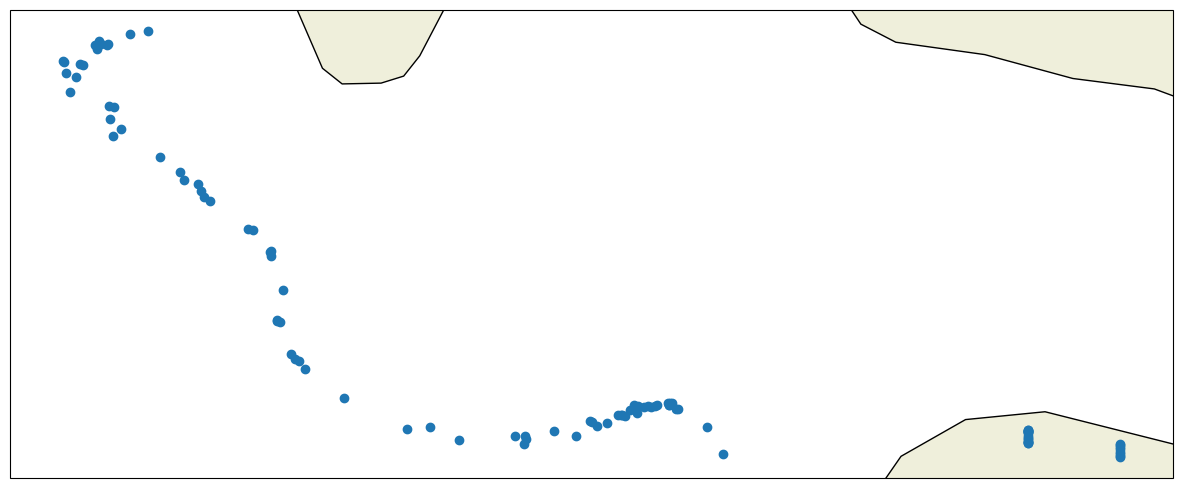

In [ ]:
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(
    1,1,1,
    projection= ccrs.PlateCarree(),
)
ax.add_feature(cartopy.feature.LAND, edgecolor='k')
ax.scatter(
    last_lon,
    last_lat,
    transform=ccrs.Geodetic(),
)
plt.show()

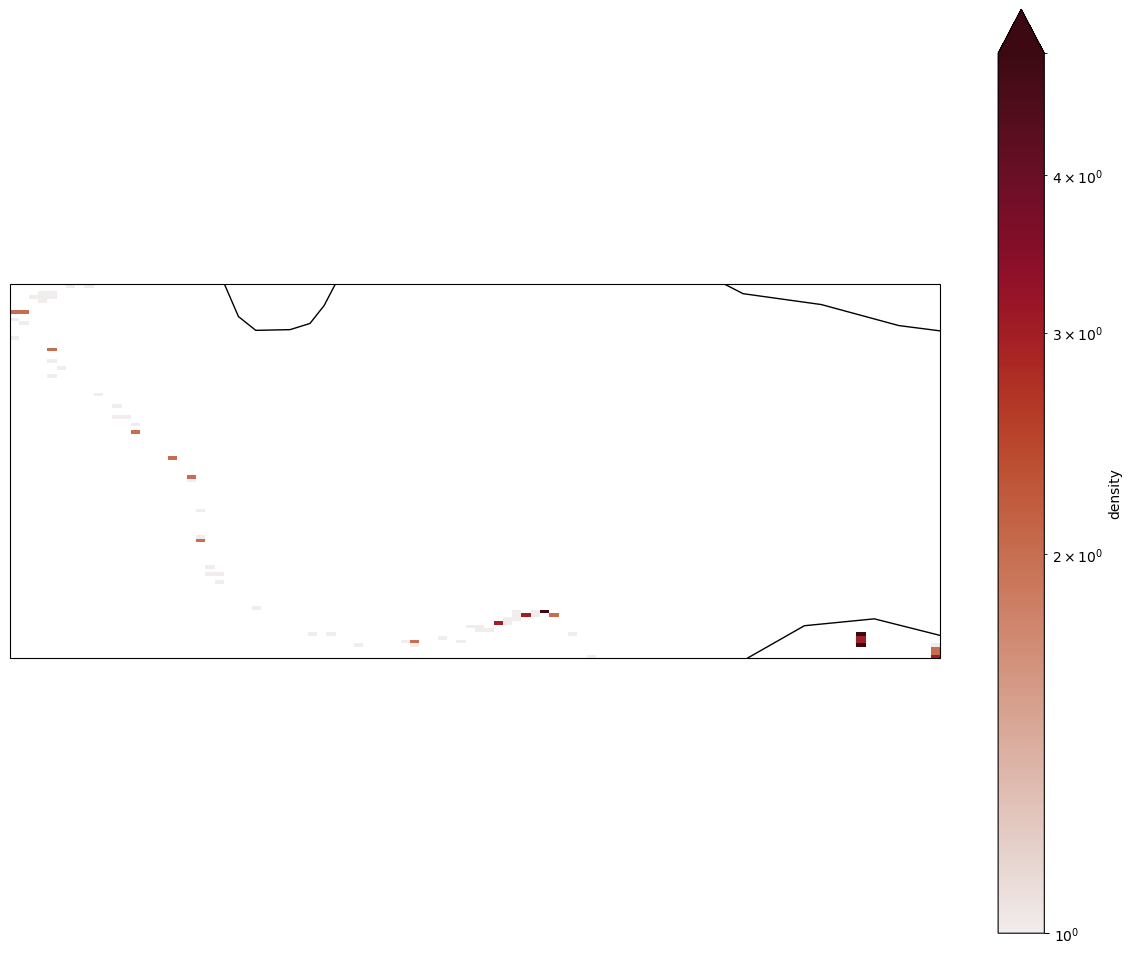

In [ ]:
fig, ax = plt.subplots(
    1,1,
    subplot_kw={'projection' : ccrs.PlateCarree()},
    figsize=(15,12),
)
ax.coastlines()
dense_plt = ax.hist2d(
    last_lon,
    last_lat,
    bins=[100, 100],
    norm=mcolors.LogNorm(),
    cmap=cmocean.cm.amp,
)
fig.colorbar(
    dense_plt[3],
    ax=ax,
    extend="max",
    label="density",
)
plt.show()